In [1]:
import sys
PATH_FOR_PROJECT = "/home/louis/Dropbox/ConsultationSimpliphAI/AnalytiqueBourassaGit/LSTM_BayesRegressor/"
sys.path.append(PATH_FOR_PROJECT)

In [2]:
from tqdm import tqdm
import itertools

from uncertainty_forecasting.models.model_data_feeder import *
from uncertainty_forecasting.visualisations.visualisations import Visualisator
from uncertainty_forecasting.models.training_tools.early_stopping import EarlyStopping


from uncertainty_forecasting.utils.time_profiler_logging import TimeProfilerLogger

logger = TimeProfilerLogger.getInstance()

import torch
import pickle

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np

seed = 13
np.random.seed(seed)
torch.manual_seed(seed)


# 0. Define experiment parameters

In [3]:
from dataclasses import dataclass

@dataclass
class ExperimentParameters:

    path: str = "/"
    version: str = "v0.0.4"
    show_figures: bool = True
    smoke_test: bool = False
    train_lstm: bool = True
    save_lstm: bool = False
    type_of_data: str = "sinus"
    name: str = "feature_extractor"

In [4]:
from uncertainty_forecasting.data_handling.data_reshaping import reshape_data_for_LSTM, reshape_into_sequences
from uncertainty_forecasting.data_generation.data_generators_switcher import DatageneratorsSwitcher

In [5]:
IS_DROPOUT_WITH_CORRELATION = True
early_stopper = EarlyStopping(patience=4, verbose=True)

experiment_params = ExperimentParameters()

experiment_params.path = PATH_FOR_PROJECT + "examples/LSTM_BayesRegressor/.models/"


experiment_params.version = "v0.1.0"
experiment_params.show_figures = True
experiment_params.smoke_test = False
experiment_params.train_lstm = True
experiment_params.save_lstm = False
experiment_params.type_of_data = "autoregressive-5" # options are sin or "autoregressive-5"
experiment_params.name = "feature_extractor_" + experiment_params.type_of_data




# 1.  generate data from ARMA process

In [6]:
n_data = 1000
length_of_sequences = 7 + 1

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


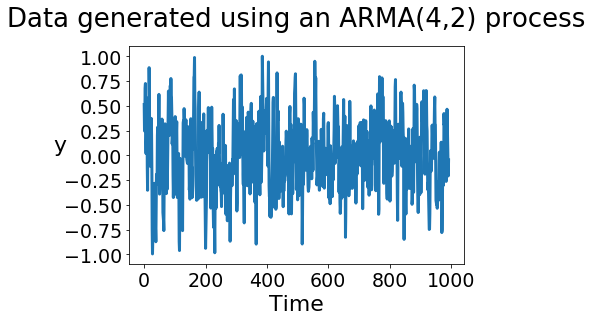

In [7]:
data_generator = DatageneratorsSwitcher(experiment_params.type_of_data)
data = data_generator(n_data)

sequences = reshape_into_sequences(data, length_of_sequences)
all_data = reshape_data_for_LSTM(sequences)

training_data_labels = all_data[length_of_sequences-1, :, 0]

number_of_train_data = floor(0.5*n_data)
val_set_end = floor(0.7*n_data)

data_train = all_data[:, :number_of_train_data, :]
data_validation = all_data[:, number_of_train_data:val_set_end, :]

if experiment_params.show_figures:
    Visualisator.show_time_series(data=all_data[length_of_sequences-2, :, 0],
                                  title="Data generated using an ARMA(4,2) process")

# 2 . Train model

## 2.1 Define parameters of model and optimizer

In [8]:
from uncertainty_forecasting.models.regression.LSTM_CorrelatedDropout.LSTM_not_correlated_dropout import LSTM_not_correlated_dropout
from uncertainty_forecasting.models.regression.LSTM_CorrelatedDropout.losses import LossRegressionGaussianNoCorrelations

from uncertainty_forecasting.models.regression.LSTM_CorrelatedDropout.LSTM_correlated_dropout import LSTM_correlated_dropout
from uncertainty_forecasting.models.regression.LSTM_CorrelatedDropout.losses import LossRegressionGaussianWithCorrelations

from uncertainty_forecasting.models.lstm_params import LSTM_parameters

In [9]:
lstm_params = LSTM_parameters()
lstm_params.batch_size = 20
lstm_params.hidden_dim = 5
lstm_params.dropout = 0.0

if experiment_params.train_lstm is False:
    lstm_params.load("lstm_params_" + experiment_params.name + "_" + experiment_params.version, experiment_params.path)

learning_rate = 1e-3
num_epochs = 2000 if not experiment_params.smoke_test else 1
num_epochs_pretraining = 2000 if not experiment_params.smoke_test else 1

In [10]:
if IS_DROPOUT_WITH_CORRELATION:
    model = LSTM_correlated_dropout(lstm_params)
else:
    model = LSTM_not_correlated_dropout(lstm_params)

In [11]:
model.cuda()
model.show_summary()

weights mu:  tensor([0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)
covariance:  tensor([[0.1227, 0.1295, 0.1197, 0.1019, 0.0863, 0.0843],
        [0.1295, 0.1527, 0.1389, 0.1124, 0.0903, 0.0841],
        [0.1197, 0.1389, 0.1627, 0.1218, 0.0971, 0.0854],
        [0.1019, 0.1124, 0.1218, 0.1163, 0.0959, 0.0935],
        [0.0863, 0.0903, 0.0971, 0.0959, 0.0906, 0.0821],
        [0.0843, 0.0841, 0.0854, 0.0935, 0.0821, 0.0957]], device='cuda:0',
       grad_fn=<MulBackward0>)
sigma:  tensor([0.0100], device='cuda:0', requires_grad=True)


In [12]:
if IS_DROPOUT_WITH_CORRELATION:
    loss_fn = LossRegressionGaussianWithCorrelations(1.0, lstm_params.hidden_dim)
else:
    loss_fn = LossRegressionGaussianNoCorrelations(1.0, lstm_params.hidden_dim)

In [13]:
params = list(model.parameters()) + list(model.prediction_sigma)

optimizer_1 = torch.optim.Adam(itertools.chain(model.parameters(),[model.weights_mu]),
                             lr=learning_rate)

optimizer_2 = torch.optim.Adam([model.weights_mu,
                                                                   model.prediction_sigma,
                                                                  model.covariance_factor],
                             lr=5*learning_rate, 
                               eps=1e-5)

loss_function_pretraining = torch.nn.MSELoss(size_average=False)

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## 2.2 Pretraining of LSTM with auxiliary loss

In [14]:
from sklearn.metrics import mean_squared_error

if experiment_params.train_lstm:

    hist_1 = np.zeros(num_epochs_pretraining)
    for epoch in tqdm(range(num_epochs_pretraining)):
        model.hidden = model.init_hidden()
        
        if epoch % 10 == 0:
            
            losses_val, N_data_val = make_forward_pass(data_loader_sequences,
                                               model,
                                               loss_function_pretraining,
                                               data_validation,
                                               lstm_params.batch_size)
            
            val_loss = losses_val/N_data_val
            #print("Epoch ", epoch, "MSE: ", val_loss)
            early_stopper(epoch, val_loss, model)

            if early_stopper.early_stop:
                break
                
        losses, N_data = make_forward_pass(data_loader_sequences, model, loss_function_pretraining, data_train,
                                                           lstm_params.batch_size)
        
                
        hist_1[epoch] = losses

        optimizer_1.zero_grad()
        losses.backward()
        optimizer_1.step()

    model.is_pretraining = False
    model.show_summary()

 24%|██▍       | 483/2000 [00:15<00:48, 31.49it/s]

EarlyStopping counter: 1 out of 4


 25%|██▍       | 495/2000 [00:15<00:48, 30.79it/s]

EarlyStopping counter: 2 out of 4


 25%|██▌       | 503/2000 [00:15<00:49, 30.50it/s]

EarlyStopping counter: 3 out of 4


 25%|██▌       | 507/2000 [00:16<00:48, 30.88it/s]

EarlyStopping counter: 4 out of 4
Validation loss decreased (inf --> 0.052749).  Saving model ...
weights mu:  tensor([ 0.4597, -0.4769,  0.4624,  0.3606, -0.3823,  0.3258], device='cuda:0',
       requires_grad=True)
covariance:  tensor([[0.1227, 0.1295, 0.1197, 0.1019, 0.0863, 0.0843],
        [0.1295, 0.1527, 0.1389, 0.1124, 0.0903, 0.0841],
        [0.1197, 0.1389, 0.1627, 0.1218, 0.0971, 0.0854],
        [0.1019, 0.1124, 0.1218, 0.1163, 0.0959, 0.0935],
        [0.0863, 0.0903, 0.0971, 0.0959, 0.0906, 0.0821],
        [0.0843, 0.0841, 0.0854, 0.0935, 0.0821, 0.0957]], device='cuda:0',
       grad_fn=<MulBackward0>)
sigma:  tensor([0.0100], device='cuda:0', requires_grad=True)


## 2.2 Training of bayesian parameters with variational loss

In [15]:
if experiment_params.train_lstm:
    
    early_stopper_2 = EarlyStopping(patience=10, verbose=True)

    
    hist = np.zeros(num_epochs)
    for epoch in tqdm(range(num_epochs)):
        model.hidden = model.init_hidden()
        
        if epoch % 10 == 0:
            losses_val, N_data_val = make_forward_pass_output_specific(data_loader_sequences,
                                                               model,
                                                               loss_fn,
                                                               data_validation,
                                                               lstm_params.batch_size)
            
            val_loss = losses_val/N_data_val
            #print("Epoch ", epoch, "MSE: ", val_loss)
            early_stopper_2(epoch, val_loss, model)

            if early_stopper_2.early_stop:
                break
                
        losses, N_data = make_forward_pass_output_specific(data_loader_sequences,
                                                           model,
                                                           loss_fn,
                                                           data_train,
                                                           lstm_params.batch_size)
        
        
                
        hist[epoch] = losses

        optimizer_2.zero_grad()
        losses.backward()
        optimizer_2.step()


  2%|▏         | 30/2000 [00:18<19:50,  1.65it/s]

EarlyStopping counter: 1 out of 10



  2%|▏         | 40/2000 [00:24<20:43,  1.58it/s]

EarlyStopping counter: 2 out of 10



  4%|▍         | 90/2000 [00:56<21:24,  1.49it/s]

EarlyStopping counter: 1 out of 10



  5%|▌         | 100/2000 [01:03<20:43,  1.53it/s]

EarlyStopping counter: 2 out of 10



  6%|▌         | 110/2000 [01:10<19:43,  1.60it/s]

EarlyStopping counter: 3 out of 10



  6%|▋         | 130/2000 [01:22<19:32,  1.59it/s]

EarlyStopping counter: 1 out of 10



  7%|▋         | 140/2000 [01:28<18:42,  1.66it/s]

EarlyStopping counter: 2 out of 10



  8%|▊         | 150/2000 [01:35<18:19,  1.68it/s]

EarlyStopping counter: 3 out of 10



  8%|▊         | 160/2000 [01:41<18:22,  1.67it/s]

EarlyStopping counter: 4 out of 10



  8%|▊         | 170/2000 [01:47<18:17,  1.67it/s]

EarlyStopping counter: 5 out of 10



  9%|▉         | 180/2000 [01:53<18:04,  1.68it/s]

EarlyStopping counter: 6 out of 10



 10%|█         | 200/2000 [02:05<17:29,  1.72it/s]

EarlyStopping counter: 1 out of 10



 10%|█         | 210/2000 [02:11<17:56,  1.66it/s]

EarlyStopping counter: 2 out of 10



 11%|█         | 220/2000 [02:17<17:50,  1.66it/s]

EarlyStopping counter: 3 out of 10



 12%|█▏        | 230/2000 [02:23<18:08,  1.63it/s]

EarlyStopping counter: 4 out of 10



 12%|█▏        | 240/2000 [02:30<17:38,  1.66it/s]

EarlyStopping counter: 5 out of 10



 12%|█▎        | 250/2000 [02:36<18:17,  1.59it/s]

EarlyStopping counter: 6 out of 10



 13%|█▎        | 260/2000 [02:43<19:41,  1.47it/s]

EarlyStopping counter: 7 out of 10



 14%|█▎        | 270/2000 [02:49<18:57,  1.52it/s]

EarlyStopping counter: 8 out of 10



 14%|█▍        | 280/2000 [02:56<19:12,  1.49it/s]

EarlyStopping counter: 9 out of 10



 14%|█▍        | 290/2000 [03:03<19:25,  1.47it/s]

EarlyStopping counter: 10 out of 10
Validation loss decreased (inf --> 5.081072).  Saving model ...


## 2.3 Saving or loading of model if specified

In [16]:
from uncertainty_forecasting.models.disk_reader_and_writer import save_checkpoint, load_checkpoint

In [17]:
if not experiment_params.train_lstm:

    load_checkpoint(model, optimizer_2, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)

if experiment_params.save_lstm:
    save_checkpoint(model, optimizer_2, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)
    lstm_params.save(experiment_params.version, experiment_params.path)



# 3. Anlysis of results

In [18]:
y_pred, y_true = make_predictions(data_loader_sequences, model, all_data, lstm_params.batch_size)

number_of_train_data = floor(0.7*n_data)
y_train, y_test = y_true[:number_of_train_data], y_true[number_of_train_data:]

model.show_summary()

weights mu:  tensor([ 0.4610, -0.4819,  0.5185,  0.3828, -0.3966,  0.3275], device='cuda:0',
       requires_grad=True)
covariance:  tensor([[0.1322, 0.1216, 0.1058, 0.1110, 0.1022, 0.0841],
        [0.1216, 0.1227, 0.1052, 0.1043, 0.0981, 0.0757],
        [0.1058, 0.1052, 0.1127, 0.1029, 0.1002, 0.0753],
        [0.1110, 0.1043, 0.1029, 0.1232, 0.1128, 0.0905],
        [0.1022, 0.0981, 0.1002, 0.1128, 0.1066, 0.0856],
        [0.0841, 0.0757, 0.0753, 0.0905, 0.0856, 0.0843]], device='cuda:0',
       grad_fn=<MulBackward0>)
sigma:  tensor([0.0921], device='cuda:0', requires_grad=True)


## 3.1 Loss convergence

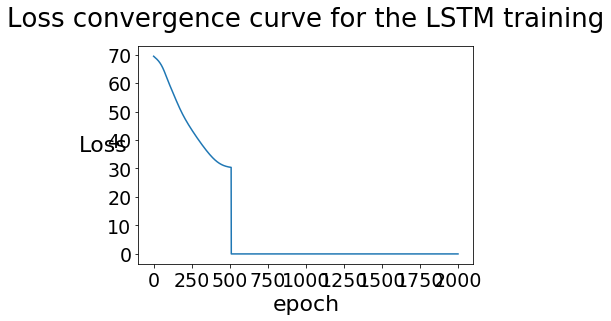

In [19]:

if experiment_params.show_figures:

    if experiment_params.train_lstm:

        Visualisator.show_epoch_convergence(data=hist_1,
                                            name="Loss",
                                            title="Loss convergence curve for the LSTM training",
                                            number_of_burned_step=0)

        

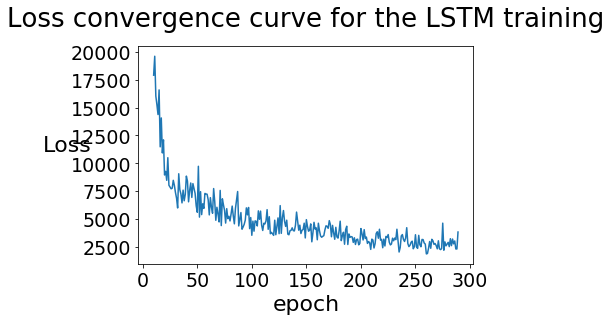

In [20]:
Visualisator.show_epoch_convergence(data=hist[:epoch],
                                            name="Loss",
                                            title="Loss convergence curve for the LSTM training",
                                            number_of_burned_step=10)

## 3.2 Visualisation of results with confidence interval

In [21]:
from uncertainty_forecasting.probabilitic_predictions.probabilistic_predictions_regression import ProbabilisticPredictionsRegression

In [22]:
%matplotlib qt 

predictions = ProbabilisticPredictionsRegression()
predictions.number_of_predictions = y_pred.shape[0]
predictions.number_of_samples = y_pred.shape[1]
predictions.initialize_to_zeros()

predictions.values = y_pred
predictions.true_values = y_true
predictions.show_predictions_with_confidence_interval(0.95)

## 3.3 Calibration analysis

In [23]:
from uncertainty_forecasting.models.calibration.diagnostics import calculate_one_sided_cumulative_calibration, calculate_confidence_interval_calibration, calculate_marginal_calibration
from uncertainty_forecasting.models.calibration.analysis import show_analysis

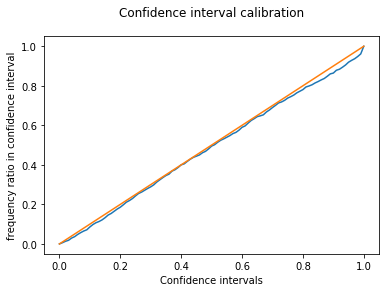

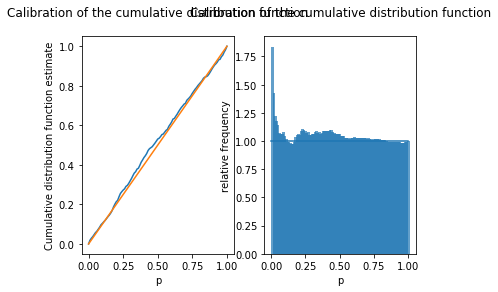

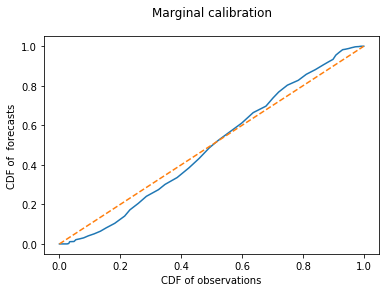

 deviation_score_probabilistic_calibration: 0.01386 
 deviation_score_exceedance_calibration: 0.01561 
 deviation_score_marginal_calibration: 0.03869 


In [24]:
%matplotlib inline 

deviation_score_probabilistic_calibration = calculate_confidence_interval_calibration(predictions.values, predictions.true_values)
deviation_score_exceedance_calibration = calculate_one_sided_cumulative_calibration(predictions.values, predictions.true_values)
deviation_score_marginal_calibration = calculate_marginal_calibration(predictions.values, predictions.true_values)



show_analysis(predictions.values, predictions.true_values, name="LSTM + dropout")

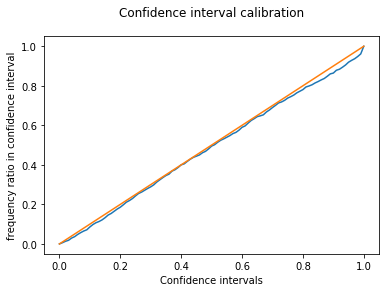

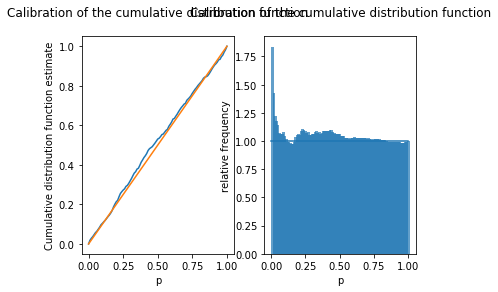

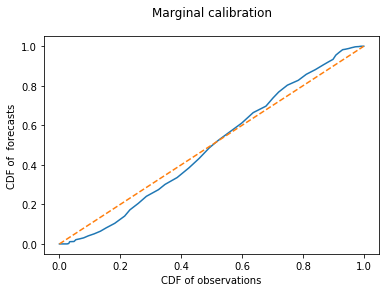

 deviation_score_probabilistic_calibration: 0.01386 
 deviation_score_exceedance_calibration: 0.01561 
 deviation_score_marginal_calibration: 0.03869 


In [25]:
show_analysis(predictions.values, predictions.true_values, name="LSTM + dropout")

In [26]:
%matplotlib qt

predictions.train_data = y_train
predictions.show_predictions_with_training_data(confidence_interval=0.95)

In [27]:
deviation_score_exceedance_calibration = calculate_one_sided_cumulative_calibration(predictions.values, predictions.true_values)
